# AI Art with Style Transfer

First, start out with some imports.

In [1]:
import os
import time
import numpy as np
import imageio
from PIL import Image
from keras import backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16, VGG19
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from scipy.optimize import minimize

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


Specify the paths for the content image, the style image, and the output image.

In [2]:
c_image_path = './initial_images/polar_bear.jpg'
s_image_path = './initial_images/sistine_chapel.jpg'
o_image_directory = './output/bear_and_sistine_chapel/'
directory = os.path.dirname(o_image_directory)
if not os.path.exists(directory):
    os.makedirs(directory)

Here are the content and style images chosen.

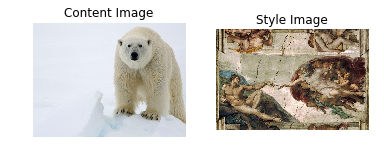

In [3]:
plt.subplot(1, 2, 1).imshow(load_img(path=c_image_path))
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2).imshow(load_img(path=s_image_path))
plt.title('Style Image')
plt.axis('off')
plt.show()

## Hyperparameters
Choose the hyperparameters for the run.

In [4]:
# Specify weights of content (alpha), style (beta), and variation (gamma) loss
alpha = 5.0
beta = 10000.0
gamma = 10.0

# Specify type of model used
model_name = 'VGG16'
Model = None
if model_name == 'VGG16':
    Model = VGG16
    preprocess_input = vgg16_preprocess
elif model_name == 'VGG19':
    Model = VGG19
    preprocess_input = vgg19_preprocess

# Specify layers to use in model for feature representations
c_layer_name = 'block4_conv2'
s_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
]

Create a text file to record the hyperparameters.

In [5]:
with open(o_image_directory + 'attributes.txt', 'w') as f:
    f.write('Attributes of Style Transfer\n\n')
    f.write(f'Content image: {c_image_path[17:]}\n')
    f.write(f'Style image: {s_image_path[17:]}\n')
    f.write(f'Model used: {model_name}\n')
    f.write(f'Alpha (content weight): {alpha}\n')
    f.write(f'Beta (style weight): {beta}\n')
    f.write(f'Gamma (total variation weight): {gamma}\n')
    f.write(f'Content layers used:\n')
    f.writelines('\t' + layer for layer in [c_layer_name])
    f.write('\n')
    f.write(f'Style layers used:\n')
    f.writelines('\t' + layer for layer in s_layer_names)
    f.write('\n')
    f.write(f'Special Notes:\n')
    f.write(f'\tNone\n')

## Image Processing

In [6]:
target_height = 512
target_width = 512
target_size = (target_height, target_width)

c_image_original = Image.open(c_image_path)
c_image_original_size = c_image_original.size
c_image = load_img(path=c_image_path, target_size=target_size)
c_image_arr = img_to_array(c_image)
c_image_arr = K.variable(preprocess_input(np.expand_dims(c_image_arr, axis=0)), dtype='float32')

s_image = load_img(path=s_image_path, target_size=target_size)
s_image_arr = img_to_array(s_image)
s_image_arr = K.variable(preprocess_input(np.expand_dims(s_image_arr, axis=0)), dtype='float32')

o_image_initial = np.random.randint(256, size=(target_width, target_height, 3)).astype('float32')
o_image_initial = preprocess_input(np.expand_dims(o_image_initial, axis=0))
o_image_placeholder = K.placeholder(shape=(1, target_width, target_height, 3))

## Content Loss
The content loss function must be formulated in order to ensure that the generated image <i>x</i> retains some of the "global" characteristics of the content image <i>p</i>. To achieve this, the content loss function is defined as the mean squared error between the <b>feature representations</b> of <i>p</i> and <i>x</i>, respectively, at a given layer <i>l</i> within the neural network:

$$ L_c(p,x,l) = \frac{1}{2}\sum_{i,j}^{} (F^l_{i,j} - P^l_{i,j})^2 $$

<ul>
    <li><i>F</i> and <i>P</i> and are matrices of size <i>N</i> x <i>M</i></li>
    <li><i>N</i> is the number of filters in layer <i>l</i> and <i>M</i> is the number of spatial elements in the feature map (height times width) for layer <i>l</i></li>
    <li><i>F</i> contains the feature representation of <i>x</i> for layer <i>l</i></li>
    <li><i>P</i> contains the feature representation of <i>p</i> for layer <i>l</i></li>
</ul>

The output of a given layer within the neural network consists of so-called <b>feature maps</b>: differently filtered versions of the input image. We can directly visualise the information each layer contains about the input image by reconstructing the image only from the <b>feature maps</b> in that layer. Higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but do not constrain the exact pixel values of the reconstruction; in contrast, reconstructions from the lower layers simply reproduce the exact pixel values of the original image. We therefore refer to the feature responses in higher layers of the network as the <b>content or feature representation</b>.

In [7]:
def get_feature_reps(layer_names, model):
    feature_matrices = []
    for layer in layer_names:
        current_layer = model.get_layer(layer)
        feature_raw = current_layer.output
        feature_raw_shape = K.shape(feature_raw).eval(session=backend_session)
        N_l = feature_raw_shape[-1]
        M_l = feature_raw_shape[1]*feature_raw_shape[2]
        feature_matrix = K.reshape(feature_raw, (M_l, N_l))
        feature_matrix = K.transpose(feature_matrix)
        feature_matrices.append(feature_matrix)
    return feature_matrices

In [8]:
def get_content_loss(F, P):
    content_loss = 0.5*K.sum(K.square(F - P))
    return content_loss

## Style Loss
Conversely, style loss is designed to preserve the stylisitc characteristics of the style image, <i>a</i>. As opposed to using the difference between feature representations, use the difference between Gram matrices from selected layers. The Gram matrix is a square matrix that contains the dot products between each vectorized filter in layer <i>l</i>, and it can therefore be thought of as a non-normalized correlation matrix for filters in the layer. The Gram matrix is defined as follows:
    
$$ G^l = F^l(F^l)^T $$

In [9]:
def get_gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

Then, the style loss contribution from layer <i>l</i> is

$$ E_l = \frac{1}{4N^2_lM^2_l} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2$$

where <i>A</i> is the Gram matrix for the style image <i>a</i> and <i>G</i> is the Gram matrix for the generated image <i>x</i>. Ascending layers in most convolutional networks such as VGG have increasingly larger receptive fields. As this receptive field grows, more large-scale characteristics of the input image are preserved. Because of this, multiple layers should be selected for “style” to incorporate both local and global stylistic qualities. To create a smooth blending between these different layers, we can assign a weight <i>w</i> to each layer, and define the total style loss as:

$$ L_s(a,x,l) = \sum_l^L w_lE_l $$

In [10]:
def get_style_loss(ws, Gs, As):
    style_loss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_gram_matrix(G)
        A_gram = get_gram_matrix(A)
        style_loss += w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return style_loss

## Total Variation Loss
Finally, total variation loss is designed to reduce the noise in an image. It is computed as the sum of the squared differences between neighboring pixels. In this context, it is used to reduce the noise of the output image and is defined as

$$ L_v(x) = \sum_{i,j} [(x_{i+1,j} - x_{i,j})^2 + (x_{i,j+1} - x_{i,j})^2] $$

In [11]:
def get_variation_loss(x):
    pixel_dif1 = K.square(x[:, :, :-1, :-1] - x[:, :, 1:, :-1])
    pixel_dif2 = K.square(x[:, :, :-1, :-1] - x[:, :, :-1, 1:])
    variation_loss = K.sum(pixel_dif1 + pixel_dif2)
    return variation_loss

## Combining the Losses
Lastly, weighting coefficients need to be assigned to both the content and style loss functions and summed to get an overall loss function.

$$ L(p, a, x, l) = \alpha L_c(p,x,l) + \beta L_s(a, x, l) + \gamma L_v(x) $$

$\alpha$, $\beta$, and $\gamma$ are hyperparameters that weight the conent, style, and variation loss, respectively, and they can be used to tune the influence of both images on the generated image. The authors of the paper recomend setting $\alpha = 1$ and $\beta = 10,000$, while $\gamma$ had no suggested value as it was not in the paper.

In [12]:
def get_total_loss(o_image_placeholder):
    F = get_feature_reps(layer_names=[c_layer_name], model=o_model)[0]
    Gs = get_feature_reps(layer_names=s_layer_names, model=o_model)
    content_loss = get_content_loss(F, P)
    style_loss = get_style_loss(ws, Gs, As)
    variation_loss = get_variation_loss(o_image_placeholder)
    total_loss = alpha*content_loss + beta*style_loss + gamma*variation_loss
    return total_loss

## Implementation
To start changing the generated image to minimize the loss function, two more functions must be defined to use scipy and the keras backend:

1. A function to calculate the total loss.
2. A function to calculate the gradient.

Both functions are fed as input into a scipy optimization function as the objective and gradient functions respectively. In this case, the limited-memory BFGS algorithm is used. It is an optimization algorithm that approximates the BFGS algorithm using a limited amount of memory, and its goal is to minimize a differentiable, scalar function over unconstrained values of its input vector. For each of the content and style images, the feature representations are extracted to construct <i>P</i> and <i>A</i> (for each selected style layer), and weight the style layers uniformly. In practice, using more than 500 iterations of L-BFGS-B creates convincing visualizations.

In [13]:
def calculate_loss(o_image_arr):
    if o_image_arr.shape != (1, target_width, target_width, 3):
        o_image_arr = o_image_arr.reshape((1, target_width, target_height, 3))
    loss_function = K.function([o_model.input], [get_total_loss(o_model.input)])
    return loss_function([o_image_arr])[0].astype('float64')

def calculate_gradient(o_image_arr):
    if o_image_arr.shape != (1, target_width, target_height, 3):
        o_image_arr = o_image_arr.reshape((1, target_width, target_height, 3))
    gradient_function = K.function([o_model.input], K.gradients(get_total_loss(o_model.input), [o_model.input]))
    gradient = gradient_function([o_image_arr])[0].flatten().astype('float64')
    return gradient

Some functions must also be defined that process the result of minimizing the loss function:

In [14]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (target_width, target_height, 3):
        x = x.reshape((target_width, target_height, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x

def save_image(x, image_number=None, title=None, target_size=c_image_original_size):
    x_image = Image.fromarray(x)
    x_image = x_image.resize(target_size)
    if image_number:
        image_path = o_image_directory + f'image_at_iteration_{image_number:03d}.jpg'
    elif title:
        image_path = o_image_directory + f'{title}.jpg'
    else:
        image_path = o_image_directory + f'output_image.jpg'
    x_image.save(image_path)
    print(f'[INFO] Image saved at {image_path}')

The following is a callback function which saves the image at certain iterations and records the time between iterations.

In [ ]:
current_iteration = 0
start_time = time.time()

def callback_image_save(xk):
    global current_iteration
    global start_time
    end_time = time.time()
    print(f'At iterate {current_iteration}, time taken: {end_time - start_time:.5f} s')
    start_time = end_time
    current_iteration += 1
    if current_iteration % 20 == 0 or current_iteration == 1:
        x_image = save_image(postprocess_array(xk), image_number=current_iteration)

Now, the VGG16 models are initialized with the respective image tensors created earlier. Instead of setting `weights` to `None` (which randomly initializes the weights), `weights` is set to `'imagenet'` (which includes the pre-trained weights on ImageNet). 

In [16]:
backend_session = K.get_session()
c_model = Model(include_top=False, weights='imagenet', input_tensor=c_image_arr)
s_model = Model(include_top=False, weights='imagenet', input_tensor=s_image_arr)
o_model = Model(include_top=False, weights='imagenet', input_tensor=o_image_placeholder)
c_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Next, the layers used to get the feature repesentations are selected.

In [17]:
# Get the feature represenations of the content and style images
P = get_feature_reps(layer_names=[c_layer_name], model=c_model)[0]
As = get_feature_reps(layer_names=s_layer_names, model=s_model)

# Initialize weights to be reciprocal of number of style layers used
ws = np.ones(len(s_layer_names)) / float(len(s_layer_names))

Finally, the image is created using the L-BFGS algorithm from scipy. Refer to terminal for progress through the minimization process.

In [ ]:
# Start the minimization process
iterations = 250
x_val = o_image_initial.flatten()
start = time.time()
try:
    minimization_options = {
        'fun': calculate_loss,
        'x0': x_val,
        'method': 'L-BFGS-B',
        'jac': calculate_gradient,
        'callback': callback_image_save,
        'options': {
            'maxiter': iterations,
            'disp': True,
        },
    }
    result = minimize(**minimization_options)
    x_output = postprocess_array(result.x)
    save_image(x_output, title='last_image')
    print('[INFO] Final image saved')
    end = time.time()
    print(f'[INFO] Time taken to run whole algorithm {iterations} iterations: {end - start:.5f} s')
finally:
    # Write number of iterations and time went through to attributes file
    with open(o_image_directory + 'attributes.txt', 'a') as f:
        f.write(f'\nNumber of iterations: {current_iteration}')
        f.write(f'\nTime: {time.time() - start:.5f} s')
    # Collect images in a gif
    images = []
    for filename in os.listdir(o_image_directory):
        if os.path.splitext(filename)[1] == '.jpg':
            images.append(imageio.imread(o_image_directory + filename))
    imageio.mimsave(o_image_directory + 'collected_images.gif', images, duration=0.3)
    print('[INFO] Saved gif of collected images')

Time taken for iteration: 42.18978 s
[INFO] Image saved at ./output/bear_and_sistine_chapel/image_at_iteration_001.jpg
Time taken for iteration: 6.52783 s
Time taken for iteration: 7.17747 s
Time taken for iteration: 7.21994 s
Time taken for iteration: 7.51313 s
Time taken for iteration: 7.72023 s
Time taken for iteration: 8.38363 s
Time taken for iteration: 8.54841 s
Time taken for iteration: 6.76020 s
Time taken for iteration: 8.61797 s
Time taken for iteration: 9.43507 s
Time taken for iteration: 9.93238 s
Time taken for iteration: 10.95905 s
Time taken for iteration: 11.18814 s
Time taken for iteration: 10.43831 s
Time taken for iteration: 11.35479 s
Time taken for iteration: 11.66202 s
Time taken for iteration: 12.38645 s
Time taken for iteration: 12.95461 s
Time taken for iteration: 13.01589 s
[INFO] Image saved at ./output/bear_and_sistine_chapel/image_at_iteration_020.jpg
Time taken for iteration: 12.90335 s
Time taken for iteration: 13.61661 s
Time taken for iteration: 14.4509